In [38]:
import dataloader
from pydantic import BaseModel
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import geopy.distance
from datetime import datetime
import pandas as pd
from schemas import Machine, Position
import joblib
import lightgbm as lgbm
from lightgbm import early_stopping, record_evaluation
from sklearn.metrics import classification_report

In [3]:
class points_times(BaseModel):
    points: list[tuple[float, float]] = []
    times: list[datetime] = []

class predicted_load_dump(BaseModel):
    load: points_times = points_times()
    dump: points_times = points_times()

class stats(BaseModel): #Represents actual data
    all_positions: list[Position] = []  # Positions recorded during a day
    load: points_times = points_times() # Load points and times
    dump: points_times = points_times() # Dump points and times
    day_speeds: list[float] = []        # Speeds
    day_acceleration: list[float] = []
    day_dists: list[float] = []         # Distances between each recording
    day_times: list[datetime] = []      # Timestamp for two above lists
    inner_prods: list[float] = []       # Inner product of consecutive normalized driving vectors
    # lat1_minus_lat0 = []
    # lon1_minus_lon0 = []

In [40]:
class automated_load_dump_for_machine():

    def __init__(self, 
                 machine_data: Machine): 
                #  load_cluster_centers: typing.Any,# Both should be list[tuple[float, float]], should implement 
                #  dump_cluster_centers: typing.Any) -> None:
        
        self.machine = machine_data
        self.predicted = predicted_load_dump()
        self.stats = stats()

        all_pos = [trips.positions for trips in self.machine.trips]
        self.stats.all_positions = [item for sublist in all_pos for item in sublist]
        self.stats.load.points = [trips.load_latlon for trips in self.machine.trips]
        self.stats.load.times = [trips.positions[0].timestamp for trips in self.machine.trips]
        self.stats.dump.points = [trips.dump_latlon for trips in self.machine.trips]
        
        actual_dump_times = []
        for t in self.machine.trips:        #Not pretty, because we don't have dump time in trip info by default
            temp_dump_laton = t.dump_latlon # Must match latlons
            for position in t.positions:
                if temp_dump_laton == (position.lat, position.lon):
                    actual_dump_times.append(position.timestamp)
                    break
        self.stats.dump.times = actual_dump_times
               
        # self.meters_from_last_act = [] 
        # self.seconds_since_last_act = [] 
        # self.is_next_load = []          


    def get_data(self):
        
        #We keep track of how many meters we have driven since last dump or load    
        meters_since_last_activity = 0
        time_since_last_activity = 0
        # add initial values where we have the load
        # self.meters_from_last_act.append(0)
        # self.seconds_since_last_act.append(0)
        # self.is_next_load.append(0)
        self.stats.day_times.append(self.stats.all_positions[0].timestamp)
        # speed is added in the loop

        #We start predicting. Are going to iterate over all positions, from first to last
        ###
        ###
        for i in range(1,len(self.stats.all_positions)-1):
            
            next_pos = self.stats.all_positions[i+1]
            current_pos = self.stats.all_positions[i]
            prev_pos = self.stats.all_positions[i-1]

            #Meters driven since last timestamp
            meters_driven = geopy.distance.geodesic((current_pos.lat, current_pos.lon), (prev_pos.lat, prev_pos.lon)).m
            
            meters_since_last_activity += meters_driven


            #Meters driven since last timestamp

            # this is the speed at point i-1 (forward derivative)
            #Seconds passed since last timestamp
            seconds_gone_i_minus_1 = (current_pos.timestamp.to_pydatetime()-prev_pos.timestamp.to_pydatetime()).total_seconds()
            time_since_last_activity += seconds_gone_i_minus_1

            seconds_gone_i = (next_pos.timestamp.to_pydatetime()-current_pos.timestamp.to_pydatetime()).total_seconds()
            meters_driven_i = geopy.distance.geodesic((next_pos.lat, next_pos.lon), (current_pos.lat, current_pos.lon)).m
            # if time duplicates, use a speed equal NaN
            try:
                speed_ms_i_minus_1 = meters_driven/seconds_gone_i_minus_1  # m/s
                speed_ms_i = meters_driven_i/seconds_gone_i # m/s
                
                # speed_kmh_i_minus_1 = speed_ms_i_minus_1*3.6  # km/h
                # speed_kmh_i = (speed_ms_i)*3.6                # km/h
                acceleration_i_minus_1 = (speed_ms_i - speed_ms_i_minus_1) / (seconds_gone_i_minus_1) # m/s^2
            except ZeroDivisionError:
                # speed_kmh_i_minus_1 = np.nan
                speed_ms_i_minus_1 = np.nan
                acceleration_i_minus_1 = np.nan
            
            self.stats.day_acceleration.append(acceleration_i_minus_1)  # m/s^2
            self.stats.day_speeds.append(speed_ms_i_minus_1)           # m/s
            
            self.stats.day_times.append(current_pos.timestamp)
            

            # if we have either load or dump, distance and time from last activity is set to 0
            for sublist in [self.stats.load.points, self.stats.dump.points]:
                if (self.stats.all_positions[i].lat, self.stats.all_positions[i].lon) in sublist:#, self.stats.dump.points]:
                    meters_since_last_activity=0
                    time_since_last_activity = 0
                    
            # self.seconds_since_last_act.append(time_since_last_activity)
            
            # self.meters_from_last_act.append(meters_since_last_activity/1000) # km

            

        
    def get_df_with_ml_data(self):
        load_times_set = set(self.stats.load.times)
        dump_times_set = set(self.stats.dump.times)
        positions = self.stats.all_positions
        latitude = [sublist.lat for sublist in positions]
        longitude = [sublist.lon for sublist in positions]
        uncertainty = [sublist.uncertainty for sublist in positions]
        lat1_minus_lat0 = [latitude[i] - latitude[i-1] for i in range(1,len(latitude))]
        lon1_minus_lon0 = [longitude[i] - longitude[i-1] for i in range(1,len(longitude))]
        # append some value to be removed after df is constructed
        lat1_minus_lat0.append(lat1_minus_lat0[-1])
        lon1_minus_lon0.append(lon1_minus_lon0[-1])
        speed_north_south = np.zeros_like(np.array(latitude))
        speed_east_west = np.zeros_like(np.array(latitude))


        # add some speed to the day_speeds list, as we we dont have the speed of the last data point ( see for loop)
        # we have to add a value as the speed in the last point is not defined as it uses forward derivative
        for _ in range(2):
            self.stats.day_speeds.append(np.nan)
            self.stats.day_acceleration.append(np.nan)
        for idx in range(1,len(latitude)-1):
            try:
                total_seconds = (self.stats.day_times[idx].to_pydatetime() - self.stats.day_times[idx-1].to_pydatetime()).total_seconds()
                speed_east_west[idx-1] = ((longitude[idx] - longitude[idx-1]   ) / total_seconds)
                speed_north_south[idx-1] = ((latitude[idx] - latitude[idx-1]   ) / total_seconds)
            except ZeroDivisionError:
                speed_east_west[idx-1] = np.nan
                speed_north_south[idx-1] = np.nan

        # add another day time as the for loop excludes the last value
        # this value will be removed anyways
        self.stats.day_times.append(self.stats.day_times[-1])
        load = [time in load_times_set for time in self.stats.day_times]
        dump = [time in dump_times_set for time in self.stats.day_times]
        # return True if either dump or load is True
        output_labels = [d or l for d, l in zip(dump, load)]
        
        for i in range(len(output_labels)):
            current_time = self.stats.day_times[i]  # The current timestamp
            if current_time in self.stats.load.times:
                output_labels[i] = "Load"
            elif current_time in self.stats.dump.times:
                output_labels[i] = "Dump"
            else:
                output_labels[i] = "Driving"

        # #  is_next_load takes 1 if True and 0 if False
        # # we have already added 0 to the list as the first value is Load
        # previous_was_load = True
        # for label in output_labels[1:]:
        #     if label == "Load":
        #         previous_was_load = True
        #     if label == "Dump":
        #         previous_was_load = False
        #     if previous_was_load:
        #         self.is_next_load.append(0)
        #     if not previous_was_load:
        #         self.is_next_load.append(1)

        
        
        
        # print('len(speed) :', len(self.stats.day_speeds))
        # print('len(acceleration)', len(self.stats.day_acceleration))
        # print('len lon: ', len(longitude))
        # print('len lat:' , len(latitude))
        # print('Load', len(load))
        # print('dump', len(dump))
        # print('datetime', len(self.stats.day_times))
        # print('machine id', self.machine.machine_id)
        # # print('meters from last act', len(self.meters_from_last_act))
        # print("output_labels", len(output_labels))
        # print("is_next_load", self.is_next_load)
        # print("seconds from last act", len(self.seconds_since_last_act))
        #  create Dataframe with the given variables
        # we dont have the speed for the last datapoint as it uses forward derivative scheme
        df = pd.DataFrame({
            "MachineID": [self.machine.machine_id]*len(self.stats.day_times),
            "DateTime": self.stats.day_times,
            # "Time_from_start": [(time.min - self.stats.day_times[0].min) for time in self.stats.day_times],
            "Speed": self.stats.day_speeds,
            "Acceleration": self.stats.day_acceleration,
            # "Inner_products": self.stats.inner_prods,
            "Latitude": latitude,
            "Longitude": longitude,
            "Uncertainty": uncertainty,
            "Lat1_minus_lat0": lat1_minus_lat0,
            "Lon1_minus_lon0": lon1_minus_lon0,
            "speed_north_south": speed_north_south,
            "speed_east_west": speed_east_west,
            # "km_from_last_event": self.meters_from_last_act,
            # "seconds_from_last_event": self.seconds_since_last_act,
            # "is_next_load": self.is_next_load,
            "output_labels": output_labels
        })
        
        # filter df to remove the rows after the last dump
        last_row = df.query('output_labels == "Dump"').index[-1]
        
        df = df.loc[:last_row]

        #Here we could try to merge 3 and 3 points - example
        group_size = 5
        result_df = pd.DataFrame()
        
        for i in range(group_size):
            sub_df = df.iloc[i::group_size]
            sub_df = sub_df.reset_index(drop=True)
            new_column_names = {}
            for column_name in df.columns:
                new_column_names[column_name] = f'{column_name}_{i}'

            # Rename the columns with the updated names
            sub_df.rename(columns=new_column_names, inplace=True)

            if i == 0:
                result_df = sub_df
            else:
                result_df = pd.concat([result_df, sub_df], axis=1)

        def custom_function(row):
            for col in result_df.columns:
                if 'output_labels' in col:
                    if row[col] == 'Load':
                        return 'Load'
                    elif row[col] == 'Dump':
                        return 'Dump'
            return 'Driving'
        
        result_df['output_labels'] = result_df.apply(custom_function, axis=1)
        result_df.rename(columns={'DateTime_0': 'DateTime'}, inplace=True)
        result_df.rename(columns={'MachineID_0': 'MachineID'}, inplace=True)
        for i in range(group_size):
            result_df = result_df.drop(f'output_labels_{i}', axis=1)
            if i != 0:
                result_df = result_df.drop(f'DateTime_{i}', axis=1)
                result_df = result_df.drop(f'MachineID_{i}', axis=1)
        return result_df #df     

In [46]:
import os
from sklearn.model_selection import train_test_split

day = '05-30-2022'
machine_id = 1


df_training_all = pd.DataFrame()

trip = dataloader.TripsLoader(day)

temp_machine = trip._machines[machine_id]
# machine_of_interest = trip._machines[unique_vehicle]
automated_for_given_machine = automated_load_dump_for_machine(temp_machine)
automated_for_given_machine.get_data()
df_vehicle = automated_for_given_machine.get_df_with_ml_data()

X, y = df_vehicle.drop(["output_labels"],axis=1), df_vehicle["output_labels"]

df_training = pd.concat([X, y], axis=1).sort_values(by="DateTime")
# grouped = df_training.groupby(df_training.index //3)
# df_training.drop("DateTime")
# df_training.insert(1,"DateTime start": d)

df_training_all = pd.concat([df_training_all, df_training], axis=0)


df_training_all.dropna(inplace=True)

#df_training_all.to_csv(f"data/ml_model_data/training_data/train_{day}_{machine_id}_days_all_trucks_multi_new_feat.csv", sep=',', index=False)

In [47]:
#Load model
loaded_model = joblib.load("data/ml_model_data/models/lgm_model.bin")

In [43]:
# this is the order of the output matrix
driving_label, dump_label, load_label = loaded_model.classes_

# pred_training = loaded_model.predict_proba(X_train)
pred_testing: np.ndarray = loaded_model.predict_proba(
    df_training_all.drop(["output_labels", "MachineID", "DateTime"], axis=1)
)

df_training_all[f"proba_{driving_label}"] = pred_testing[:, 0]
df_training_all[f"proba_{dump_label}"] = pred_testing[:, 1]
df_training_all[f"proba_{load_label}"] = pred_testing[:, 2]

In [44]:
#Plot result
# Create subplots
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, vertical_spacing=0.1)

# Create a scatter plot with lines
#scatter = go.Scatter(x=df_training_all['DateTime'], y=df_training_all['proba_Driving'], mode='lines', name="Proba of driving")
#fig.add_trace(scatter, row=1, col=1)

scatter = go.Scatter(x=df_training_all['DateTime'], y=df_training_all['proba_Load'], mode='lines', name="Proba of loading")
fig.add_trace(scatter, row=1, col=1)

scatter = go.Scatter(x=df_training_all['DateTime'], y=df_training_all['proba_Dump'], mode='lines', name="Proba of dumping")
fig.add_trace(scatter, row=2, col=1)

# Add markers for specific values
markers = df_training_all[df_training_all['output_labels'] == "Load"]
scatter_markers = go.Scatter(x=markers['DateTime'], y=[0]*len(markers), mode='markers', marker=dict(symbol='star', size=10, color='red'), name="Markers for load")
fig.add_trace(scatter_markers, row=1, col=1)

markers = df_training_all[df_training_all['output_labels'] == "Dump"]
scatter_markers = go.Scatter(x=markers['DateTime'], y=[0]*len(markers), mode='markers', marker=dict(symbol='star', size=10, color='blue'), name="Markers for dump")
fig.add_trace(scatter_markers, row=2, col=1)
# Add traces to the subplot



# Update layout
fig.update_layout(title='Plot of computed probabilities driving, load, and dump',
                  xaxis=dict(title='Datetime'),
                  showlegend=True)

# Show the plot
fig.show()

In [48]:
# pred_training = loaded_model.predict_proba(X_train)
pred_testing: np.ndarray = loaded_model.predict(
    df_training_all.drop(["output_labels", "MachineID", "DateTime"], axis=1)
)

In [49]:
df_training_all["prediction"] = pred_testing

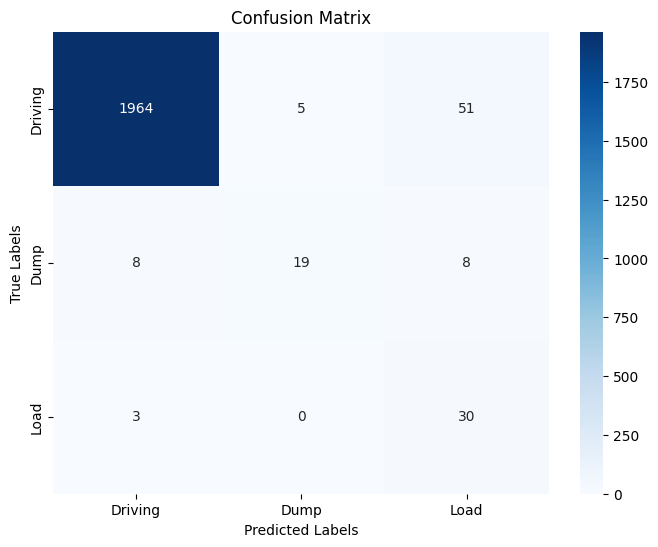

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_true = df_training_all["output_labels"]
y_pred = df_training_all["prediction"]
# Assuming you have 'y_true' (true labels) and 'y_pred' (predicted labels) defined
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Driving', 'Dump', 'Load'], yticklabels=['Driving', 'Dump', 'Load'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [54]:


# Assuming you have 'y_true' (true labels) and 'y_pred' (predicted labels) defined
class_report = classification_report(y_true, y_pred)

print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     Driving       1.00      0.99      0.99      1395
        Dump       0.59      0.94      0.72        18
        Load       0.69      0.86      0.77        21

    accuracy                           0.98      1434
   macro avg       0.76      0.93      0.83      1434
weighted avg       0.99      0.98      0.98      1434



In [52]:
#Bringing everything together
#Doing it over 50 days example and plot precision, recall and accuracy
import os
from sklearn.model_selection import train_test_split

#day = '05-30-2022'
machine_id = 38
days = [csv_file.split(".csv")[0] for csv_file in os.listdir("data/GPSData/trips")]
nb_days = 50
days = days[50:50+nb_days]
statistics = { "Driving" : {"accuracy" : [], "precision" : [], "f1-score" : []},
              "Dump" : {"accuracy" : [], "precision" : [], "f1-score" : []}, 
              "Load" : {"accuracy" : [], "precision" : [], "f1-score" : []} 
               
}
for day in days:
    try:
        print("day",)
        df_training_all = pd.DataFrame()

        trip = dataloader.TripsLoader(day)

        temp_machine = trip._machines[machine_id]
        # machine_of_interest = trip._machines[unique_vehicle]
        automated_for_given_machine = automated_load_dump_for_machine(temp_machine)
        automated_for_given_machine.get_data()
        df_vehicle = automated_for_given_machine.get_df_with_ml_data()

        X, y = df_vehicle.drop(["output_labels"],axis=1), df_vehicle["output_labels"]

        df_training = pd.concat([X, y], axis=1).sort_values(by="DateTime")
        # grouped = df_training.groupby(df_training.index //3)
        # df_training.drop("DateTime")
        # df_training.insert(1,"DateTime start": d)

        df_training_all = pd.concat([df_training_all, df_training], axis=0)


        df_training_all.dropna(inplace=True)

        loaded_model = joblib.load("data/ml_model_data/models/lgm_model.bin")

        # pred_training = loaded_model.predict_proba(X_train)
        pred_testing: np.ndarray = loaded_model.predict(
            df_training_all.drop(["output_labels", "MachineID", "DateTime"], axis=1)
        )

        df_training_all["prediction"] = pred_testing

        y_true = df_training_all["output_labels"]
        y_pred = df_training_all["prediction"]

        # Assuming you have 'y_true' (true labels) and 'y_pred' (predicted labels) defined
        class_report = classification_report(y_true, y_pred, output_dict=True)

        for activity in ["Driving", "Dump", "Load"]:
            statistics[activity]["precision"].append(class_report[activity]["precision"])
            statistics[activity]["f1-score"].append(class_report[activity]["f1-score"])
    except:
        print("Didnt work.")

    

day
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
day
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
Didnt work.
day
day
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Didnt work.
day
day
Could not add row, row was type:  <class 'float'>  but expected ndarray.
Could not add row, row was type:  <class 'float'>  but expected ndarray.
day
Could not add row, row was type:  <class 'float'>  but expected ndarray.
day
day
day
day
day
day
day
day


In [20]:
statistics

{'Driving': {'accuracy': [],
  'precision': [0.9981879368366554,
   0.9988084599344653,
   1.0,
   0.9987225641621182,
   1.0,
   0.9997983057684551,
   0.9993989662219017,
   0.9995386389850057,
   0.9998494202680319,
   0.9992822537233088,
   0.9991403765150864,
   0.9993457943925234,
   0.9993964268469339,
   0.9993242101706369,
   0.9987467362924282,
   0.9988564894225271],
  'f1-score': [0.989479086476777,
   0.9902539870053161,
   0.996282527881041,
   0.9861819849779255,
   0.9984802431610942,
   0.993187737928271,
   0.9925978987583572,
   0.9919871794871794,
   0.9920812789481548,
   0.9913662661326212,
   0.9931641459454841,
   0.9924819008724708,
   0.9905479779851639,
   0.9873143047905191,
   0.9860796040420705,
   0.9886114451439485]},
 'Dump': {'accuracy': [],
  'precision': [0.18181818181818182,
   0.11320754716981132,
   0.0,
   0.1891891891891892,
   0.0,
   0.19642857142857142,
   0.23387096774193547,
   0.23478260869565218,
   0.4189189189189189,
   0.13125,
   0.17

In [53]:

for activity in ["Driving", "Dump", "Load"]: 
    trace1 = go.Scatter(x=days, y=statistics[activity]["precision"], mode='lines', name='Precision')
    trace2 = go.Scatter(x=days, y=statistics[activity]["f1-score"], mode='lines', name='f1-score')

    data = [trace1, trace2]

    layout = go.Layout(title=f'{activity} predictions',
                    xaxis=dict(title='Dates'),
                    yaxis=dict(title='Score',  range=[0,1]))

    fig = go.Figure(data=data, layout=layout)

    fig.show()